# Connect to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries

In [2]:
!pip install pydub

# Import libraries

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment
import soundfile as sf
from collections import Counter
import librosa
import librosa.display
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Define dataset paths

In [ ]:
# Paths to the directories of the four datasets
dataset_paths = {
    'FTSpeech': 'F:\\MS_Thesis\\dataset\\raw\\ftspeech',
    'NST Danish ASR Database': 'F:\\MS_Thesis\\dataset\\raw\\nst_wavs-20231031T095324Z-001\\nst_wavs\\clips',
    'Nota audio and text data': 'F:\\MS_Thesis\\dataset\\raw\\RMHL20130002\\RMHL20130002',
    'Mozilla Common Voice': 'F:\\MS_Thesis\\dataset\\raw\\cv-corpus-16.1-2023-12-06\\da\\clips'
}

# EDA - Audio Data

## Common funtions

In [ ]:
def get_audio_durations(folder_path):
    audio_durations = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.wav', '.mp3', '.flac')):  # Add other audio formats if needed
                file_path = os.path.join(root, file)
                try:
                    audio = AudioSegment.from_file(file_path)
                    duration = len(audio) / 1000.0  # Duration in seconds
                    audio_durations.append(duration)
                except Exception as e:
                    print(f"Could not process {file_path}: {e}")

    return audio_durations

## Summary statistics

In [ ]:
def calculate_statistics(durations):
    if not durations:
        return {
            'Max Duration (s)': None,
            'Min Duration (s)': None,
            'Avg Duration (s)': None,
            'Median Duration (s)': None,
            'Std Dev Duration (s)': None,
            'Total Audio Files': 0
        }

    max_duration = max(durations)
    min_duration = min(durations)
    avg_duration = sum(durations) / len(durations)
    median_duration = sorted(durations)[len(durations) // 2]
    std_dev_duration = (sum((x - avg_duration) ** 2 for x in durations) / len(durations)) ** 0.5

    return {
        'Max Duration (s)': max_duration,
        'Min Duration (s)': min_duration,
        'Avg Duration (s)': avg_duration,
        'Median Duration (s)': median_duration,
        'Std Dev Duration (s)': std_dev_duration,
        'Total Audio Files': len(durations)
    }

In [ ]:
# Prepare a list to hold the statistics for each dataset
stats_list = []

# Process each dataset and calculate statistics
for dataset_name, dataset_path in dataset_paths.items():
    print(f"Processing {dataset_name}...")
    durations = get_audio_durations(dataset_path)
    stats = calculate_statistics(durations)
    stats['Dataset'] = dataset_name
    stats_list.append(stats)

# Create a DataFrame from the list of statistics
stats_df = pd.DataFrame(stats_list)

# Display the statistics in a table
print(stats_df)

Processing FTSpeech...
Processing NST Danish ASR Database...
Processing Nota audio and text data...
Processing Mozilla Common Voice...
   Max Duration (s)  Min Duration (s)  Avg Duration (s)  Median Duration (s)  \
0          6041.364          1783.118       3554.415000             3314.886   
1            14.984             0.784          4.902495                4.584   
2            80.600             0.199         20.178227               21.591   
3            25.380             0.900          4.121568                3.888   

   Std Dev Duration (s)  Total Audio Files                   Dataset  
0           1137.747745                 15                  FTSpeech  
1              2.638396                957   NST Danish ASR Database  
2             17.055792                194  Nota audio and text data  
3              1.643842              10928      Mozilla Common Voice  


In [ ]:
# Optional: Save the statistics to an Excel file
stats_df.to_excel('audio_statistics.xlsx', index=False)

## Distribution of audio duration

In [ ]:
def plot_duration_distribution(durations, dataset_name):
    plt.figure(figsize=(10, 6))
    plt.hist(durations, bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Duration Distribution for {dataset_name}')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Processing FTSpeech...


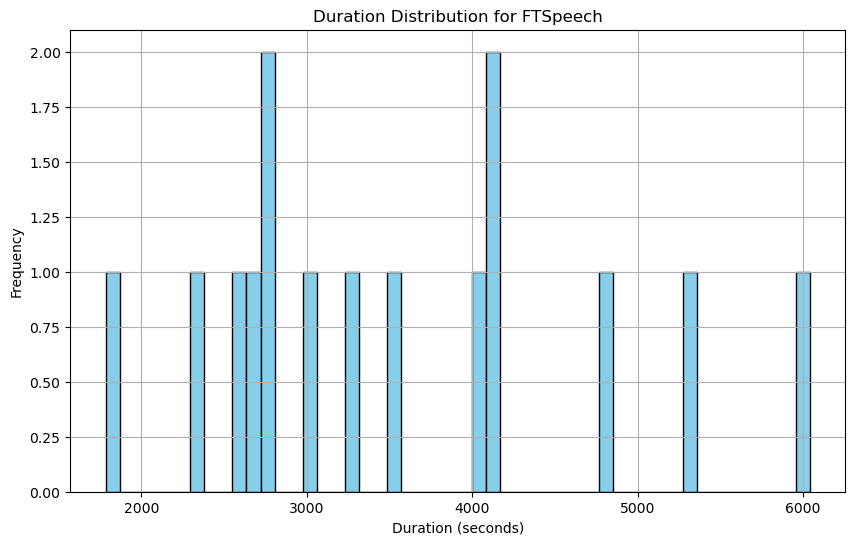

Processing NST Danish ASR Database...


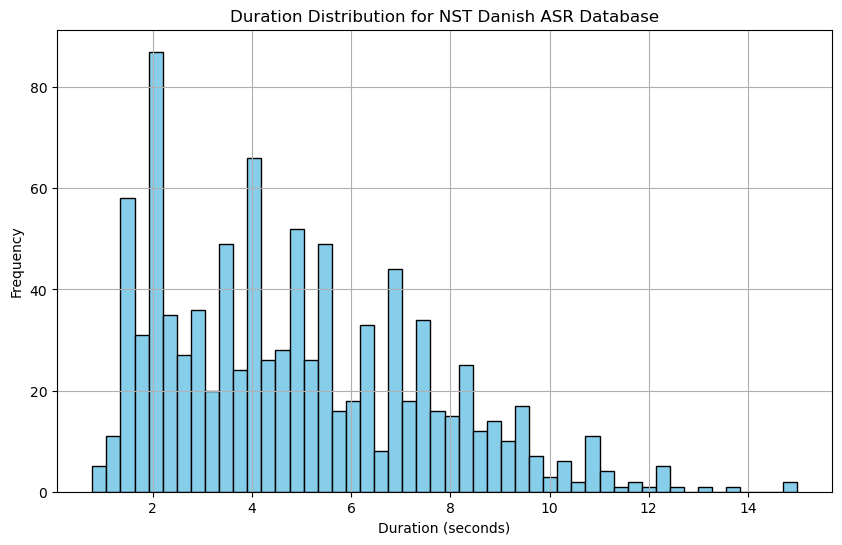

Processing Nota audio and text data...


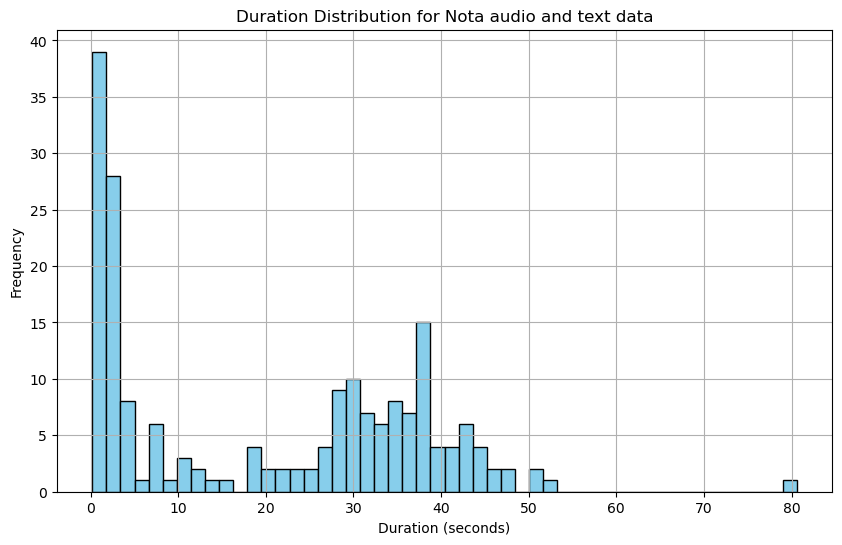

Processing Mozilla Common Voice...


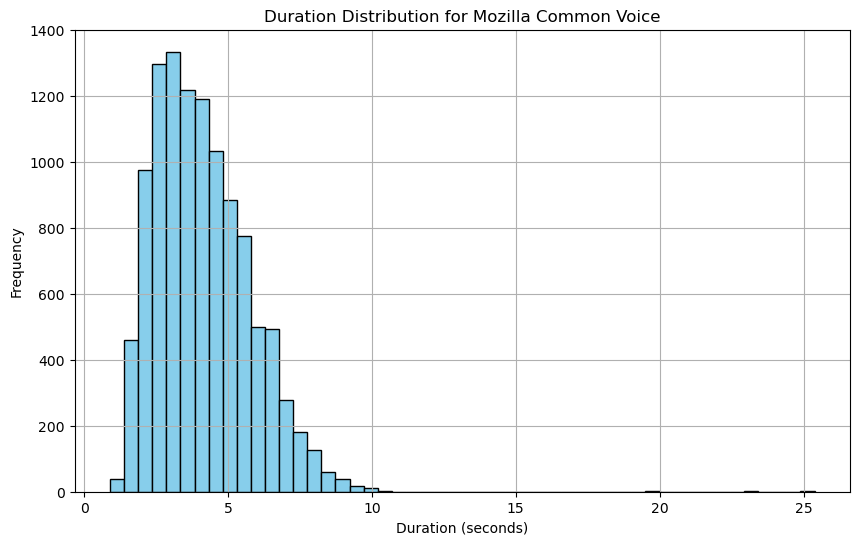

In [ ]:
# Plot duration distributions for each dataset
for dataset_name, dataset_path in dataset_paths.items():
    print(f"Processing {dataset_name}...")
    durations = get_audio_durations(dataset_path)
    if durations:
        plot_duration_distribution(durations, dataset_name)
    else:
        print(f"No audio files found in {dataset_path}")

## Audio data characteristics

In [ ]:
def get_audio_properties(folder_path):
    audio_properties = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.wav', '.mp3', '.flac', '.ogg', '.m4a', '.aac')):  # Add other audio formats if needed
                file_path = os.path.join(root, file)
                try:
                    with sf.SoundFile(file_path) as audio:
                        file_extension = os.path.splitext(file)[1].lower()
                        sample_rate = audio.samplerate
                        channels = audio.channels
                        is_mono = channels == 1
                        audio_properties.append((file_extension, sample_rate, is_mono))
                except Exception as e:
                    print(f"Could not process {file_path}: {e}")

    return audio_properties

In [ ]:
# Prepare a dictionary to hold the properties summary for each dataset
properties_summary = {}

# Process each dataset and collect audio properties
for dataset_name, dataset_path in dataset_paths.items():
    print(f"Processing {dataset_name}...")
    properties = get_audio_properties(dataset_path)
    properties_summary[dataset_name] = properties


# Summarize the audio properties for each dataset
formats_list = []

for dataset_name, properties in properties_summary.items():
    format_counts = Counter([prop[0] for prop in properties])
    sample_rate_counts = Counter([prop[1] for prop in properties])
    mono_counts = sum([1 for prop in properties if prop[2]])

    for format, count in format_counts.items():
        formats_list.append({
            'Dataset': dataset_name,
            'Format': format,
            'Count': count,
            'Sample Rates': sample_rate_counts,
            'Mono Count': mono_counts
        })

formats_df = pd.DataFrame(formats_list)

# Display the formats summary in a table
print(formats_df)

Processing FTSpeech...
Processing NST Danish ASR Database...
Processing Nota audio and text data...
Processing Mozilla Common Voice...
                    Dataset Format  Count    Sample Rates  Mono Count
0                  FTSpeech   .wav     15     {16000: 15}          15
1   NST Danish ASR Database   .wav    957    {16000: 957}         957
2  Nota audio and text data   .wav    194    {44100: 194}         194
3      Mozilla Common Voice   .mp3  10928  {32000: 10928}       10928


In [ ]:
# Optional: Save the formats summary to an Excel file
formats_df.to_excel('audio_data_characteristics.xlsx', index=False)

## Audio Noise Detection

In [ ]:
def draw_spectrogram(directory):
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.endswith('.wav'):
            # Load the audio file
            y, sr = librosa.load(filepath)

            # Compute the spectrogram
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

            # Plot the spectrogram
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Spectrogram for {}'.format(filename))
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.tight_layout()
            plt.show()

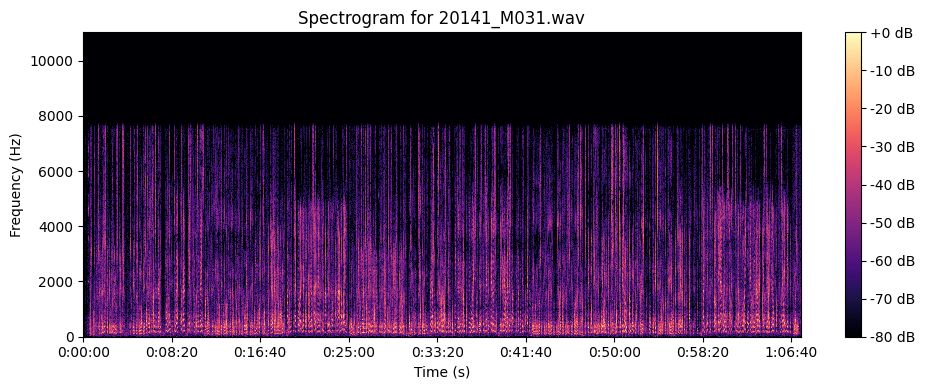

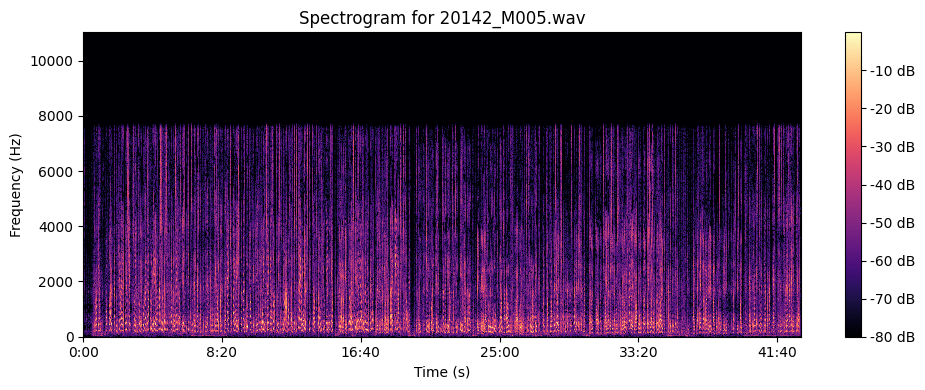

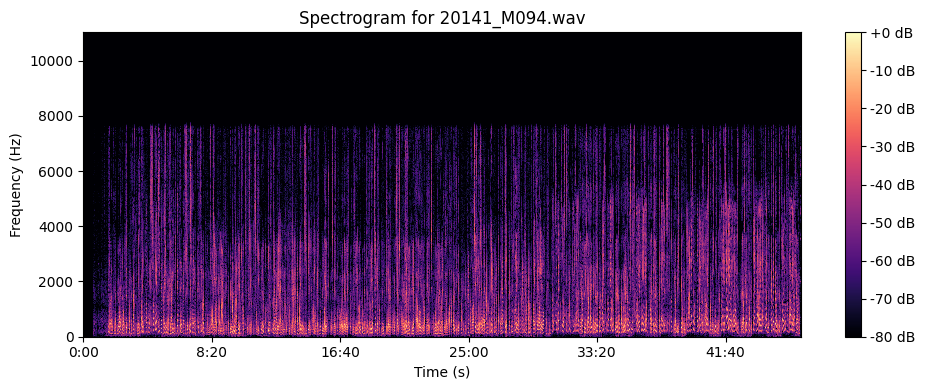

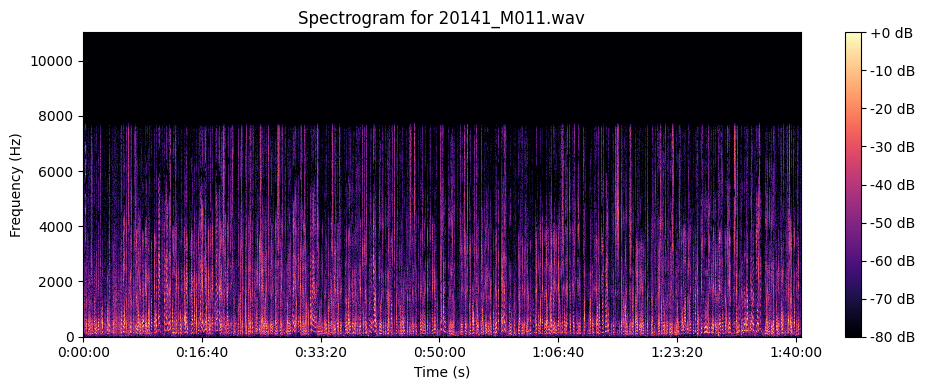

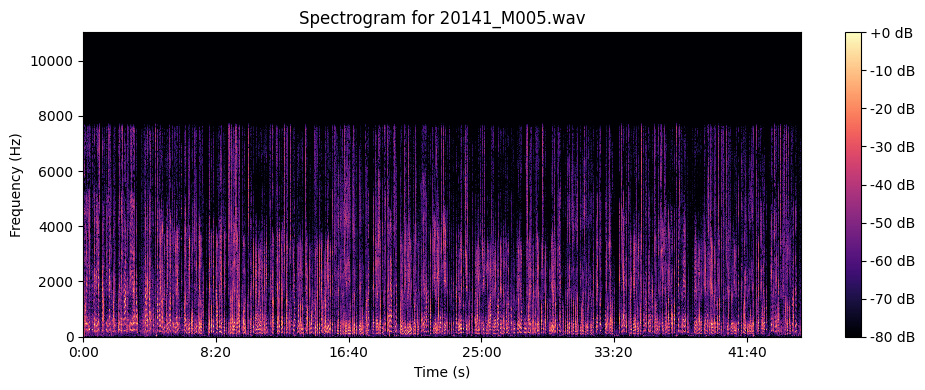

In [ ]:
directory = '/content/drive/MyDrive/Audio_Data/ftspeech'
draw_spectrogram(directory)

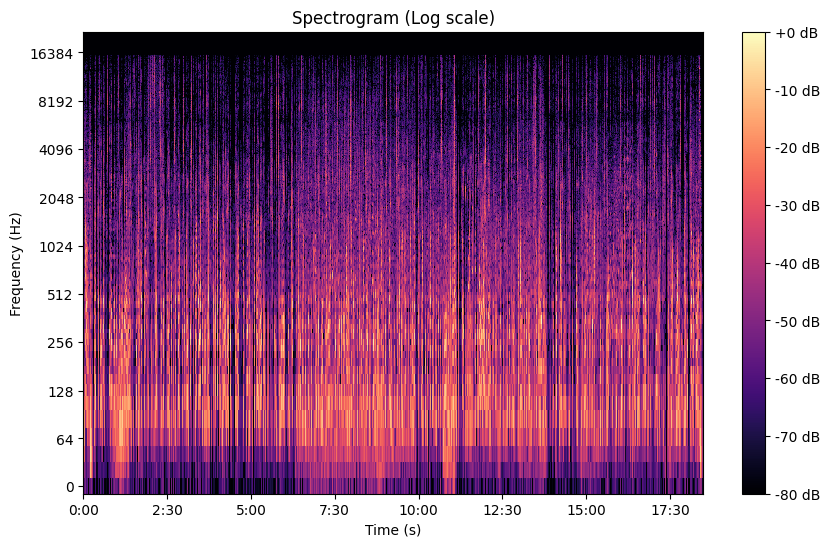

In [5]:
# Load the audio file
audio_file = "/content/drive/MyDrive/Audio_Data/ingolfianernes_garage.mp3"
y, sr = librosa.load(audio_file, sr=None)

# Compute the spectrogram
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (Log scale)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Insights from Audio EDA

There are several key takeaways from the EDA as follows:
*   The audio statistics and length distribution indicate that the FTSpeech and NST datasets need to be divided since their durations are significantly
longer than what the model expects.
*   Common voice datasets need to be converted to wav format before proceeding.
*   For every dataset, audio sampling is necessary.
*   Noisy data from audiobooks and FTSpeech has to be cleaned.

# EDA - Text Data

## Text Length Distribution

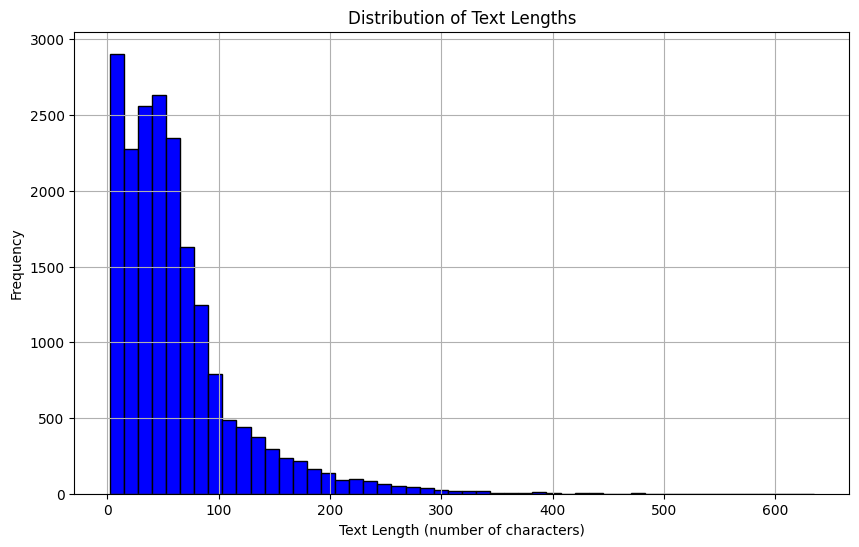

In [4]:
# Load the metadata file
with open("/content/drive/MyDrive/tts-dataset/metadata.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Extract the text part after the "|" symbol
texts = [line.split('|')[1].strip() for line in lines]

# Create a DataFrame
df = pd.DataFrame(texts, columns=['text'])

# Calculate the length of each sentence
df['text_length'] = df['text'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (number of characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Vocabulary Analysis

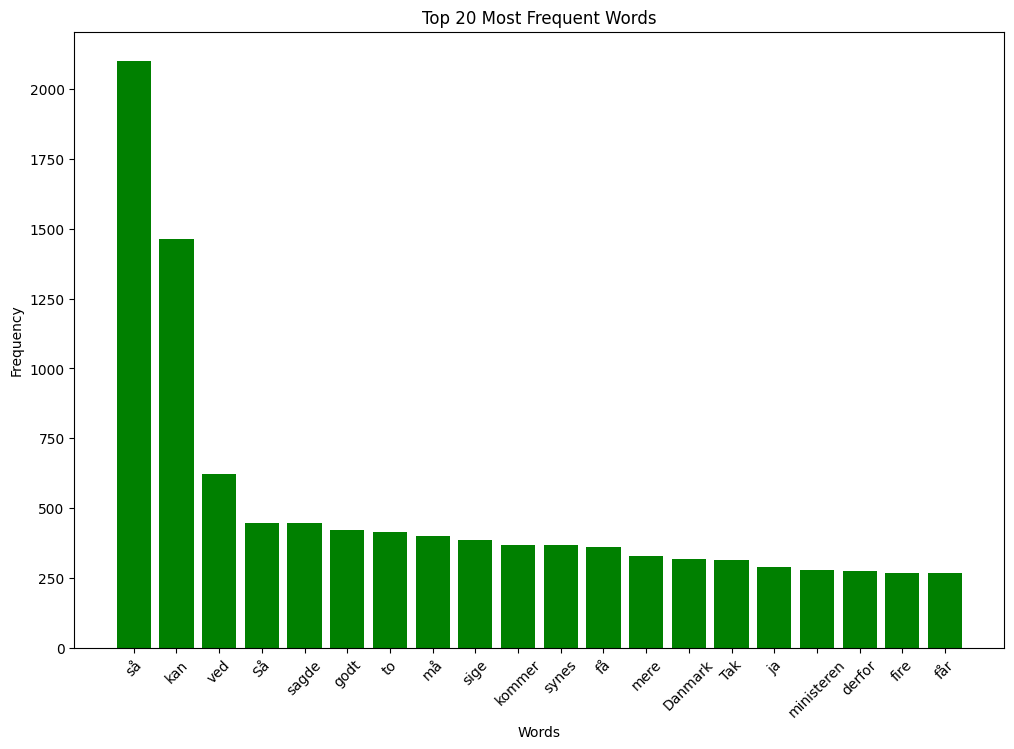

In [16]:
# Tokenize the text data and filter out non-alphabetic tokens
words = [word for word in nltk.word_tokenize(" ".join(df['text'])) if word.isalpha()]

# Remove stopwords
stop_words = set(stopwords.words('danish'))
filtered_words = [word for word in words if word.lower() not in stop_words]

# Calculate the frequency of each word
word_freq = Counter(filtered_words)

# Convert to a DataFrame for better visualization
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Plot the top 20 most frequent words
plt.figure(figsize=(12, 8))
plt.bar(word_freq_df['word'][:20], word_freq_df['frequency'][:20], color='green')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


               Statistic   Value
0  Total Vocabulary Size  205942
1      Unique Word Count   21210


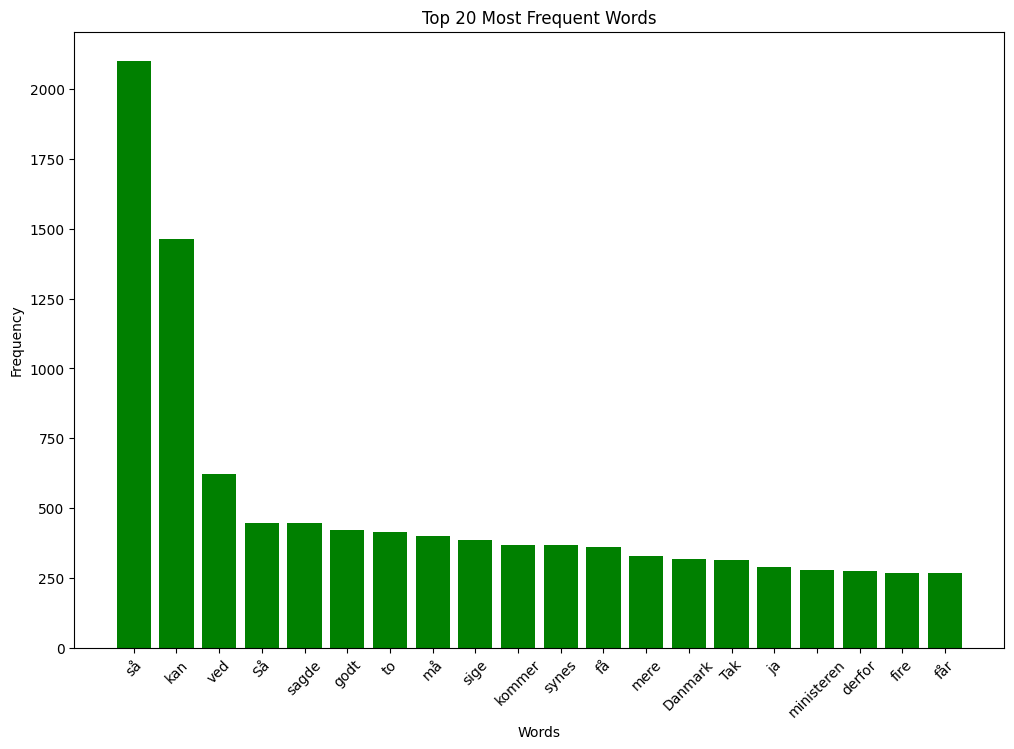

In [5]:
# import pandas as pd
# import nltk
# from nltk.corpus import stopwords
# from collections import Counter
# import matplotlib.pyplot as plt

# # Ensure necessary NLTK resources are downloaded
# nltk.download('punkt')
# nltk.download('stopwords')

# Load the text data
# Assuming `df` is a DataFrame containing your text data in a column named 'text'
# df = pd.read_csv('your_text_data.csv')  # Example of loading data

# Tokenize the text data and filter out non-alphabetic tokens
words = [word for word in nltk.word_tokenize(" ".join(df['text'])) if word.isalpha()]

# Remove stopwords
stop_words = set(stopwords.words('danish'))
filtered_words = [word for word in words if word.lower() not in stop_words]

# Calculate the frequency of each word
word_freq = Counter(filtered_words)

# Calculate total vocabulary size and unique word counts
total_vocabulary_size = len(words)
unique_word_count = len(word_freq)

# Create a DataFrame to present the statistics
vocab_stats_df = pd.DataFrame({
    'Statistic': ['Total Vocabulary Size', 'Unique Word Count'],
    'Value': [total_vocabulary_size, unique_word_count]
})

print(vocab_stats_df)

# Convert to a DataFrame for better visualization of word frequencies
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Plot the top 20 most frequent words
plt.figure(figsize=(12, 8))
plt.bar(word_freq_df['word'][:20], word_freq_df['frequency'][:20], color='green')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [14]:
vocab_stats_df

,Statistic,Value
0,Total Vocabulary Size,205942
1,Unique Word Count,21210


<ipython-input-11-8c72a5a9ed55>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Value', y='Statistic', data=vocab_stats_df, palette='Dark2')


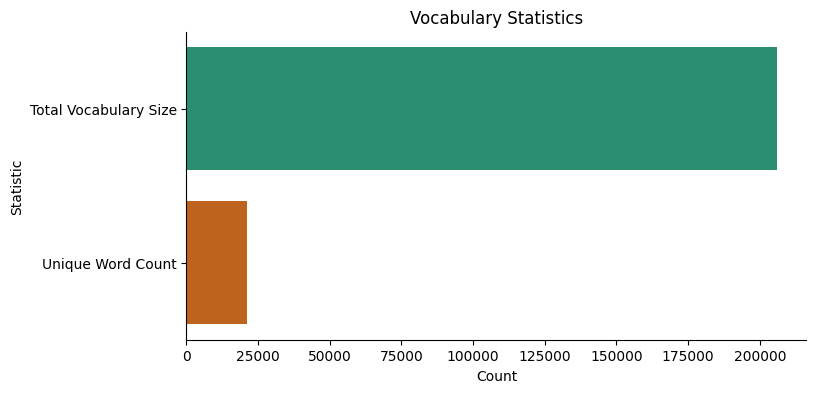

In [11]:
# Plot the vocabulary statistics
plt.figure(figsize=(8, 4))
sns.barplot(x='Value', y='Statistic', data=vocab_stats_df, palette='Dark2')
plt.title('Vocabulary Statistics')
plt.xlabel('Count')
plt.ylabel('Statistic')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

## Sentence Structure Analysis

count    19336.000000
mean        12.408875
std         10.858717
min          1.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        125.000000
Name: word_count, dtype: float64


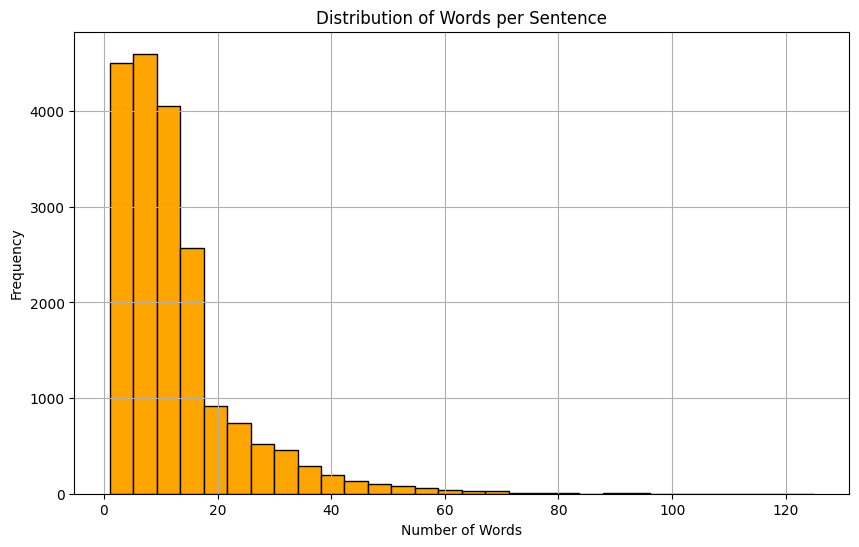

In [19]:
# Calculate the number of words per sentence
df['word_count'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

# Summary statistics for sentence length
sentence_stats = df['word_count'].describe()
print(sentence_stats)

# Plot the distribution of words per sentence
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Words per Sentence')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Common N-Grams

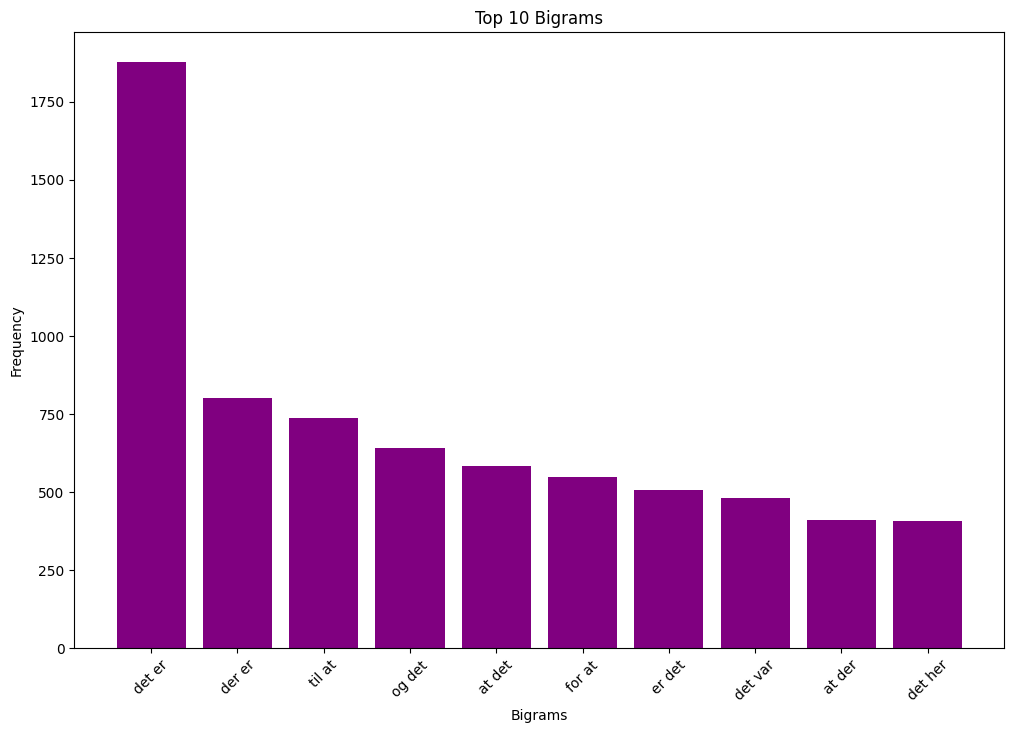

In [9]:
# Function to get n-grams
def get_top_n_grams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 10 bigrams
top_10_bigrams = get_top_n_grams(df['text'], 10, 2)
top_10_bigrams_df = pd.DataFrame(top_10_bigrams, columns=['bigram', 'frequency'])

# Plot the top 10 bigrams
plt.figure(figsize=(12, 8))
plt.bar(top_10_bigrams_df['bigram'], top_10_bigrams_df['frequency'], color='purple')
plt.title('Top 10 Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## Insights from Text EDA

The following are a few significant facts to learn from this EDA:
* Despite having a varied range of vocabulary, it lacks terms related to
healthcare, which are commonly used in conversations between healthcare
professionals and patients.
* Presence of both long and short texts with appropriate length in the
dataset will make the training effective.
* Bigram is comparable to the merged tokens produced by the BPE tokenizer, demonstrating the tokenizer's potential.
* Given the scale of this study, the overall vocabulary size is decent, with
some sentences in the text dataset being duplicates, according to strategy.
